<a href="https://colab.research.google.com/github/Bibhash123/JSTARS-NESNet/blob/main/Validation_%26_Benchmarking/NO2_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bibhash123/ireland2021
!unzip ireland2021.zip -d "/content/dataset"
!rm ireland2021.zip
from IPython.display import clear_output
clear_output(wait=False)

In [2]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import utils

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

In [4]:
files = pd.read_csv("/content/dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [5]:

def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true,pred):
  # assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

In [6]:
def loadData(df,satdir = "/content/dataset/satellite/",gdir = "/content/dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2).flatten()      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0).flatten(),np.stack(Y,axis=0).flatten()

In [7]:
def getDayWise(Y):
  x = Y.shape[0]//3283
  day_wise = []
  for i in range(1,x+1,1):
    day_wise.append(Y[(i-1)*3283:i*3283])
  return np.stack(day_wise,axis=0)

In [8]:
from sklearn.linear_model import LinearRegression

scores_list = []
rmses = []
maes = []
pearsons = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  model = LinearRegression()
  model.fit(X_train.reshape(-1,1),Y_train.reshape(-1,1))

  pred = model.predict(X_val.reshape(-1,1))
  rmse = mean_squared_error(Y_val,pred,squared=False)
  mae = mean_absolute_error(Y_val,pred)
  rmses.append(rmse)
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(getDayWise(Y_val),getDayWise(pred)[:,:,0])
  r2 = np.mean([i for i in ls if not pd.isnull(i)])
  pearsons.append(r2)

  print("Fold {} Pearson coeff avg over days: {}".format(fold,r2))
  scores_list.append(ls)
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))
print("\nCV Pearson coeff avg over days: {}".format(np.mean(pearsons)))


Fold 0

Fold 0 RMSE Score: 8.04099695866094
Fold 0 Pearson coeff avg over days: 0.08522754578219918

Fold 1

Fold 1 RMSE Score: 9.646911780774055
Fold 1 Pearson coeff avg over days: 0.07577245777999031

Fold 2

Fold 2 RMSE Score: 8.750869512512457
Fold 2 Pearson coeff avg over days: 0.06767917069439142

Fold 3

Fold 3 RMSE Score: 8.255221453838372
Fold 3 Pearson coeff avg over days: 0.08651048221729894

Fold 4

Fold 4 RMSE Score: 8.283215752539709
Fold 4 Pearson coeff avg over days: 0.08796809601647614

CV RMSE Score: 8.595443091665107

CV MAE Score: 6.271226802812157

CV Pearson coeff avg over days: 0.0806315504980712


In [22]:
ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323] #Irealand Extent
llcrn,urcrn = (-9.4003,51.8285),(-6.032,54.323) # Ireland bounds
# llcrn,urcrn = (-6.37,53.282),(-6.11,53.47) # dublin bounds
num_cols = int((urcrn[0]-llcrn[0])//0.05)
num_rows = int((urcrn[1]-llcrn[1])//0.05)
lat_cords = np.linspace(llcrn[1],urcrn[1]+0.05,num_rows)
lon_cords = np.linspace(llcrn[0],urcrn[0]+0.05,num_cols)
lon,lat = np.meshgrid(lon_cords,lat_cords)

In [26]:
inp = getDayWise(X_val)[10].reshape((49,67))
pred = getDayWise(model.predict(X_val.reshape(-1,1)))[10].reshape((49,67))
true = getDayWise(Y_val)[10].reshape((49,67))

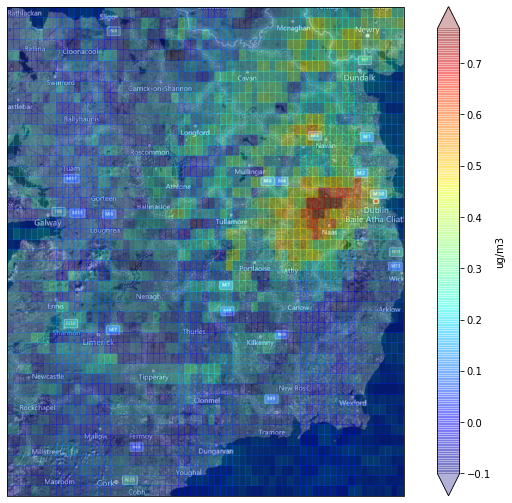

In [27]:
utils.plotMap(inp,lon,lat,ireland_bound)

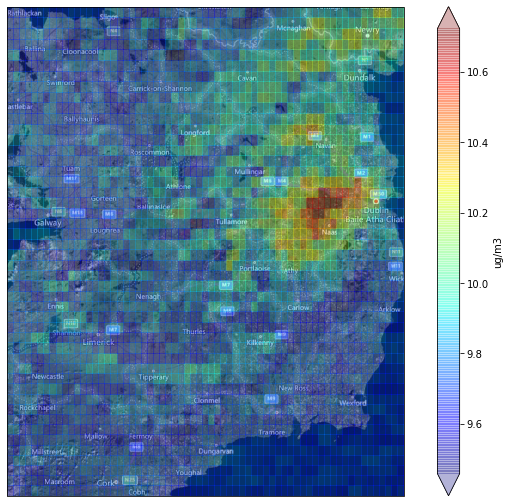

In [28]:
utils.plotMap(pred,lon,lat,ireland_bound)

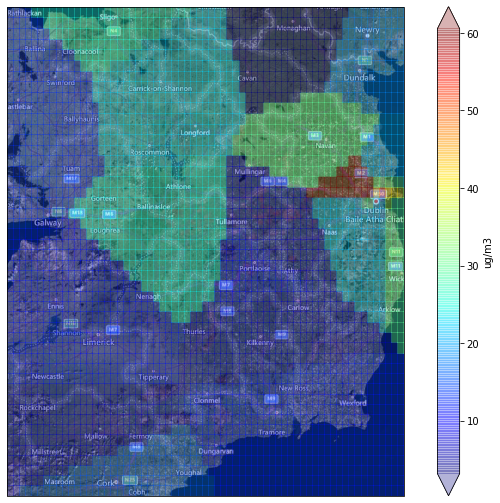

In [29]:
utils.plotMap(true,lon,lat,ireland_bound)

In [30]:
from xgboost import XGBRegressor

scores_list = []
rmses = []
maes = []
pearsons = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  model = XGBRegressor(objective="reg:squarederror")
  model.fit(X_train.reshape(-1,1),Y_train.reshape(-1,1))

  rmse = mean_squared_error(Y_val,model.predict(X_val.reshape(-1,1)),squared=False)
  mae = mean_absolute_error(Y_val,model.predict(X_val.reshape(-1,1)))
  rmses.append(rmse)
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(getDayWise(Y_val),getDayWise(model.predict(X_val.reshape(-1,1)))[:,:])
  r2 = np.mean([i for i in ls if not pd.isnull(i)])
  pearsons.append(r2)

  print("Fold {} Pearson coeff avg over days: {}".format(fold,r2))
  scores_list.append(ls)
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))
print("\nCV Pearson coeff avg over days: {}".format(np.mean(pearsons)))


Fold 0

Fold 0 RMSE Score: 7.9557582251855585
Fold 0 Pearson coeff avg over days: 0.03372149061656979

Fold 1

Fold 1 RMSE Score: 9.645708080378448
Fold 1 Pearson coeff avg over days: 0.06263680448949949

Fold 2

Fold 2 RMSE Score: 8.619868891761797
Fold 2 Pearson coeff avg over days: 0.042575083203024465

Fold 3

Fold 3 RMSE Score: 8.215765107047895
Fold 3 Pearson coeff avg over days: 0.04848931695197552

Fold 4

Fold 4 RMSE Score: 8.23459226878722
Fold 4 Pearson coeff avg over days: 0.04351926163916595

CV RMSE Score: 8.534338514632184

CV MAE Score: 6.217653208144083

CV Pearson coeff avg over days: 0.04618839138004704


In [31]:
inp = getDayWise(X_val)[10].reshape((49,67))
pred = getDayWise(model.predict(X_val.reshape(-1,1)))[10].reshape((49,67))
true = getDayWise(Y_val)[10].reshape((49,67))

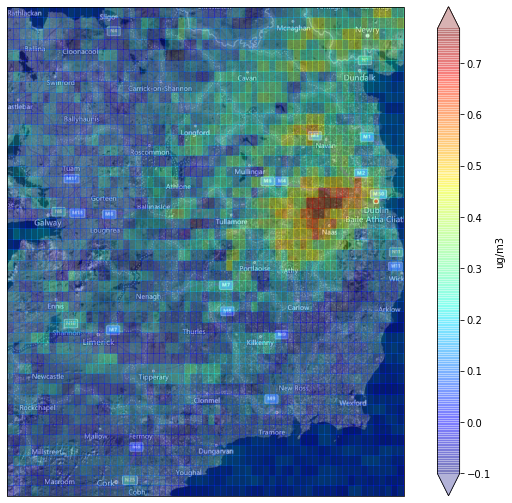

In [32]:
utils.plotMap(inp,lon,lat,ireland_bound)

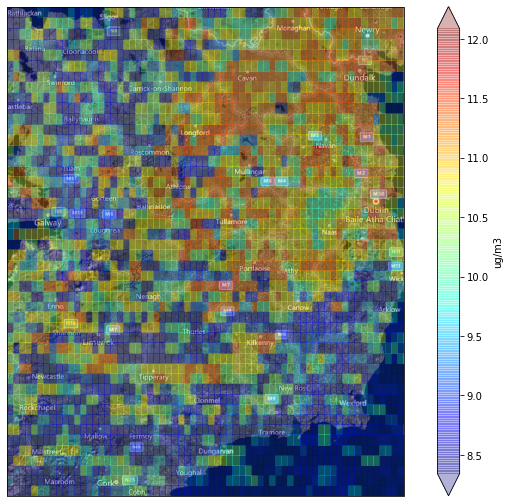

In [33]:
utils.plotMap(pred,lon,lat,ireland_bound)

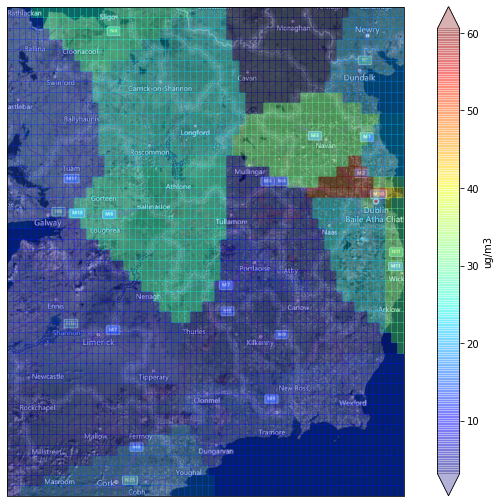

In [34]:
utils.plotMap(true,lon,lat,ireland_bound)

In [35]:
from lightgbm import LGBMRegressor

In [36]:

scores_list = []
rmses = []
maes = []
pearsons = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  model = LGBMRegressor()
  model.fit(X_train.reshape(-1,1),Y_train.flatten())

  rmse = mean_squared_error(Y_val,model.predict(X_val.reshape(-1,1)),squared=False)
  mae = mean_absolute_error(Y_val,model.predict(X_val.reshape(-1,1)))
  rmses.append(rmse)
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(getDayWise(Y_val),getDayWise(model.predict(X_val.reshape(-1,1)))[:,:])
  r2 = np.mean([i for i in ls if not pd.isnull(i)])
  pearsons.append(r2)

  print("Fold {} Pearson coeff avg over days: {}".format(fold,r2))
  scores_list.append(ls)
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))
print("\nCV Pearson coeff avg over days: {}".format(np.mean(pearsons)))


Fold 0

Fold 0 RMSE Score: 7.9609991044776836
Fold 0 Pearson coeff avg over days: 0.03166280755267142

Fold 1

Fold 1 RMSE Score: 9.646612966158472
Fold 1 Pearson coeff avg over days: 0.06013414630155294

Fold 2

Fold 2 RMSE Score: 8.626625626684648
Fold 2 Pearson coeff avg over days: 0.04004679812882337

Fold 3

Fold 3 RMSE Score: 8.219681446110704
Fold 3 Pearson coeff avg over days: 0.047438571562256435

Fold 4

Fold 4 RMSE Score: 8.236165020905746
Fold 4 Pearson coeff avg over days: 0.043399600642152106

CV RMSE Score: 8.53801683286745

CV MAE Score: 6.221017147366679

CV Pearson coeff avg over days: 0.04453638483749125


In [37]:
inp = getDayWise(X_val)[10].reshape((49,67))
pred = getDayWise(model.predict(X_val.reshape(-1,1)))[10].reshape((49,67))
true = getDayWise(Y_val)[10].reshape((49,67))

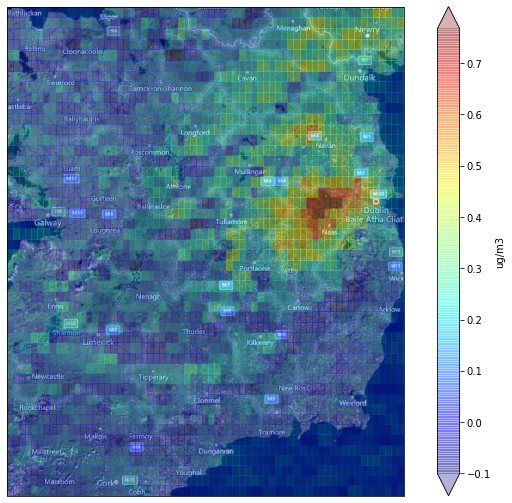

In [38]:
utils.plotMap(inp,lon,lat,ireland_bound)

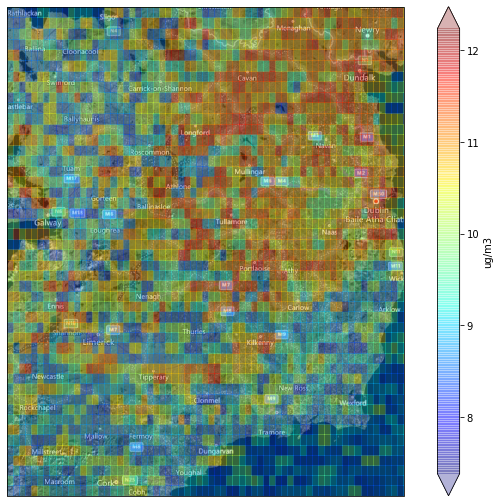

In [39]:
utils.plotMap(pred,lon,lat,ireland_bound)

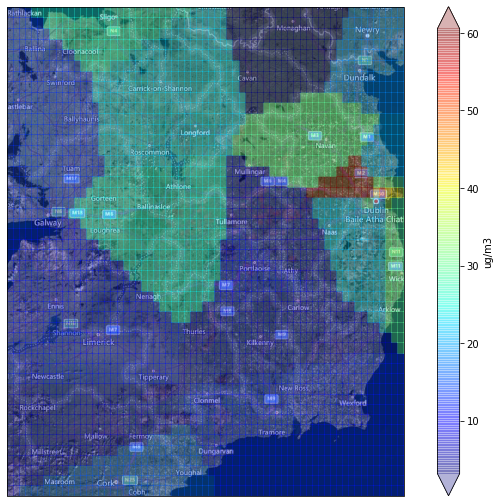

In [40]:
utils.plotMap(true,lon,lat,ireland_bound)